In [1]:
import os
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import datetime as dt
import pathlib
import pickle #to save files
from itertools import product
from scipy.stats import skew, kurtosis

# %matplotlib inline
from mpl_toolkits.mplot3d import Axes3D
%matplotlib notebook
pd.__version__

'0.20.3'

In [2]:
# Set path to folder containing Subject data Dictionaries
# path = '../Data_dict/' #dictionaries data Mac - (local, much faster)
# path = '/Volumes/RT&O/CIS-PD Study/Data_dict/' #Mac
path = r'W:\CIS-PD Study\Data_dict' #windows repo path

#path to subject scores
#pathscores = '../Scores/' #local
pathscores = r'W:\CIS-PD Study\Scores' #windows repo path
#---------------------------------------------------------------------------------------------------------

In [3]:
def plot_data(acts, activity, trial, sensor, data, start=0, end=100000):
#---------------------------------------------------------------------------------------------------------
# Plots requested data
# 
# Inputs: acts - activity dataframe containing all sensor data from one subject
#         activity - desired activity to plot
#         trial - desired trial number to plot
#         sensor - desired sensor (serial number or name of location) to analyze
#         data - desired type of data to analyze (accel, gyro, EMG/ECG)
#         start - starting index, default starts at first point
#         end - ending index, default is 500th data point
#---------------------------------------------------------------------------------------------------------
    rawdata = pd.DataFrame(acts[activity][trial]).loc[data, sensor]#[start:end]
    #reindex time (relative to start)
    idx = rawdata.index
    idx = idx-idx[0]
    rawdata.index = idx
    rawdata.plot(figsize=(8,6))

In [4]:
#list subjects in db
d = os.listdir(path)
f = [filename[:4] for filename in d if filename.startswith('1')]
print(np.sort(f))

['1004' '1016' '1018' '1019' '1020' '1024' '1029' '1030' '1032' '1038'
 '1044' '1046' '1049' '1052']


## Choose subject, task, visit and sensor location

In [5]:
subj = 1004 #choose subj to visualize

In [6]:
#load Pickle file dict
subj_filename = str(subj) + 'dict.pkl'
f = open(os.path.join(path, subj_filename), 'rb')
act_dict = pickle.load(f)
f.close()

In [7]:
#choose task, trials(visits) and sensor location
task = 'Motor #8: Typing on a Computer'
task_scores = 'Typing on a computer keyboard' #the task name in the scores file
# task = 'Motor #1: Standing'
# task_scores = 'Standing'
# task = 'Motor #3: Walking while Counting'
# task_scores = 'Walking while counting'
# task = 'Motor #2: Walking'
# task_scores = 'Walking'
# task = 'Motor #7: Drawing on Paper'
# task_scores = 'Drawing on a paper'


# loc = 'dorsal_hand_left'
loc = 'dorsal_hand_right'
# loc = 'sacrum'
# loc = 'flexor_digitorum_left'
# loc = 'flexor_digitorum_right'


trials = [0,2,4,5,6]

## Scores for current subject

In [8]:
#load subject scores
mot_scores = pd.read_excel(os.path.join(pathscores, 'MotorTasks.xls'))
#remove words:(Qxx) and 'rating' from each column for readability
cols= mot_scores.columns
cols = cols[4:]
cols = cols.tolist()
colsnew = [x.split('(')[0] for x in cols]
colsnew = [x.strip() for x in colsnew] #remove whitspace
colsnew = [x.split('rating')[0] for x in colsnew]
colsnew = [x.strip() for x in colsnew]
c = dict(zip(cols,colsnew))
mot_scores = mot_scores.rename(index=str, columns=c)

#extract scores for corresponding task and subject
subj_score = mot_scores.loc[mot_scores['Subject']==subj,['Subject','Visit',
                            task_scores+ ' ' + 'bradykinesia right upper limb',
                            task_scores+ ' ' + 'tremor right upper limb',
                            task_scores+ ' ' + 'bradykinesia left upper limb',
                            task_scores+ ' ' + 'tremor left upper limb',
                            task_scores+ ' ' + 'overall score']]
subj_score = subj_score.rename(index=str,
                               columns={subj_score.columns[2]:'Bradykinesia right',subj_score.columns[3]:'Tremor right', 
                                       subj_score.columns[4]:'Bradykinesia left',subj_score.columns[5]:'Tremor left',
                                       subj_score.columns[6]:'overall'})
subj_score.index = range(len(subj_score))
subj_score


,Subject,Visit,Bradykinesia right,Tremor right,Bradykinesia left,Tremor left,overall
0,1004,2 Weeks: Time 0,2,1,2,1,2.0
1,1004,2 Weeks: Time 30,0,0,0,0,0.0
2,1004,2 Weeks: Time 60,0,0,0,0,0.0
3,1004,2 Weeks: Time 90,0,0,0,0,0.0
4,1004,2 Weeks: Time 120,0,0,0,0,0.0
5,1004,2 Weeks: Time 150,0,0,0,0,0.0
6,1004,1 Month,0,0,0,0,0.0


## Histogram of scores for specific task and all subjects 

<IPython.core.display.Javascript object>


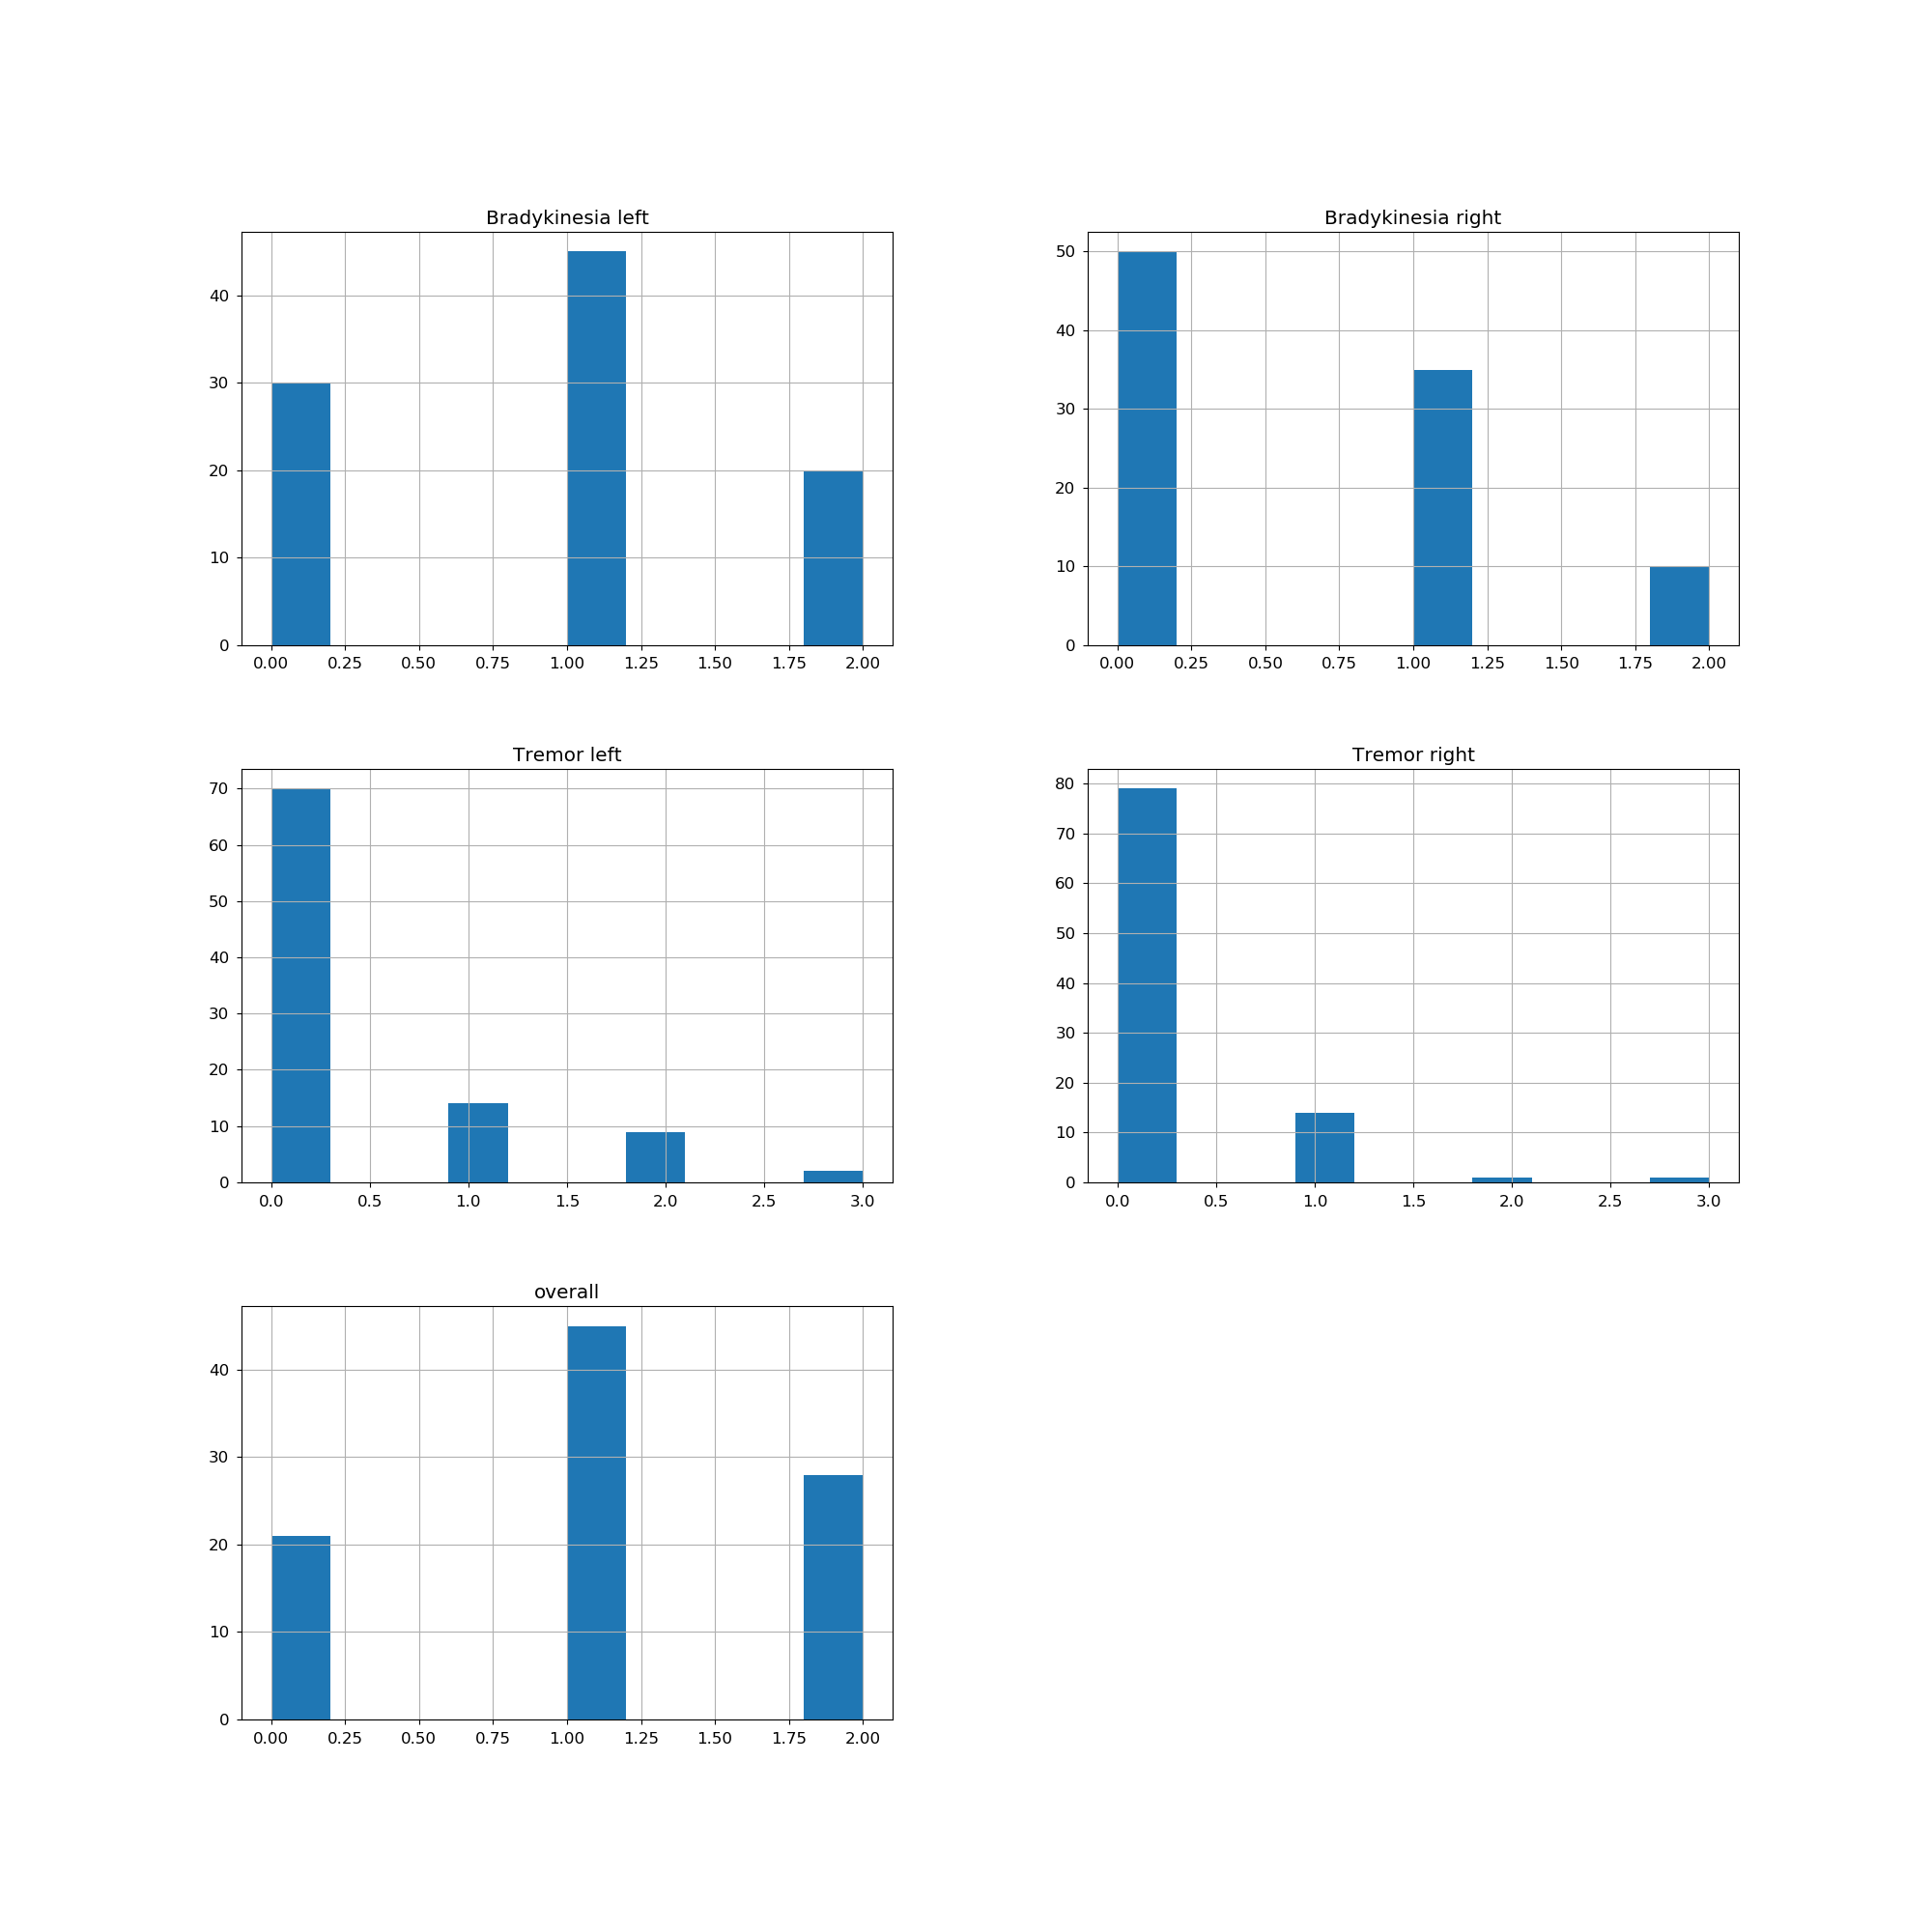

In [9]:
#histogram of motor scores from all subjects for current task
S = mot_scores[[            task_scores+ ' ' + 'bradykinesia right upper limb',
                            task_scores+ ' ' + 'tremor right upper limb',
                            task_scores+ ' ' + 'bradykinesia left upper limb',
                            task_scores+ ' ' + 'tremor left upper limb',
                            task_scores+ ' ' + 'overall score']]

S = S.rename(index=str,columns={S.columns[0]:'Bradykinesia right',S.columns[1]:'Tremor right', 
                                       S.columns[2]:'Bradykinesia left',S.columns[3]:'Tremor left',
                                       S.columns[4]:'overall'})
sns.set_context('paper',font_scale=1.5)
ax = S.hist(figsize=(20,20),xlabelsize=12,ylabelsize=12)

# Raw sensors data visualization

<IPython.core.display.Javascript object>


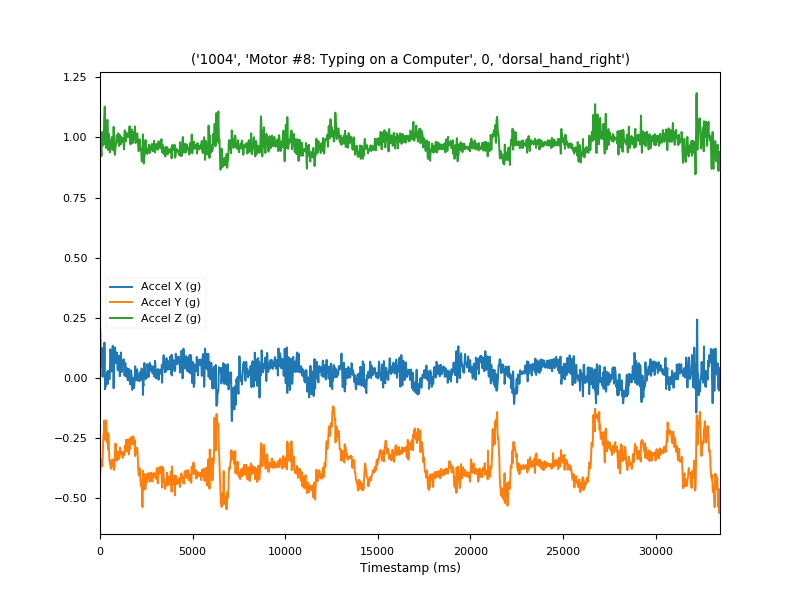

<IPython.core.display.Javascript object>


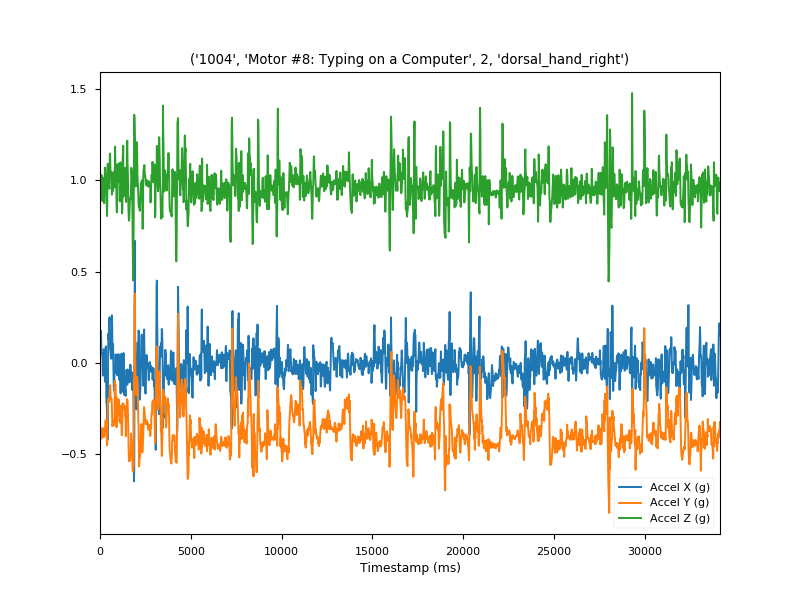

<IPython.core.display.Javascript object>


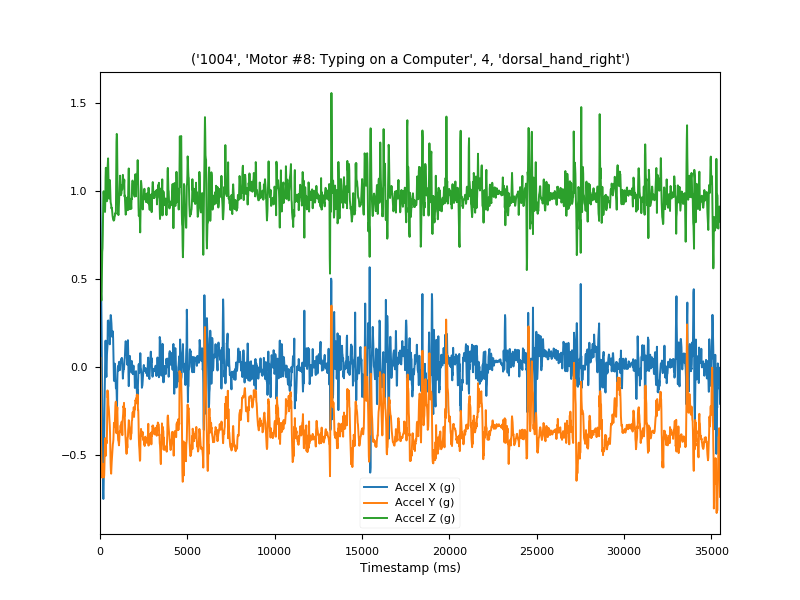

<IPython.core.display.Javascript object>


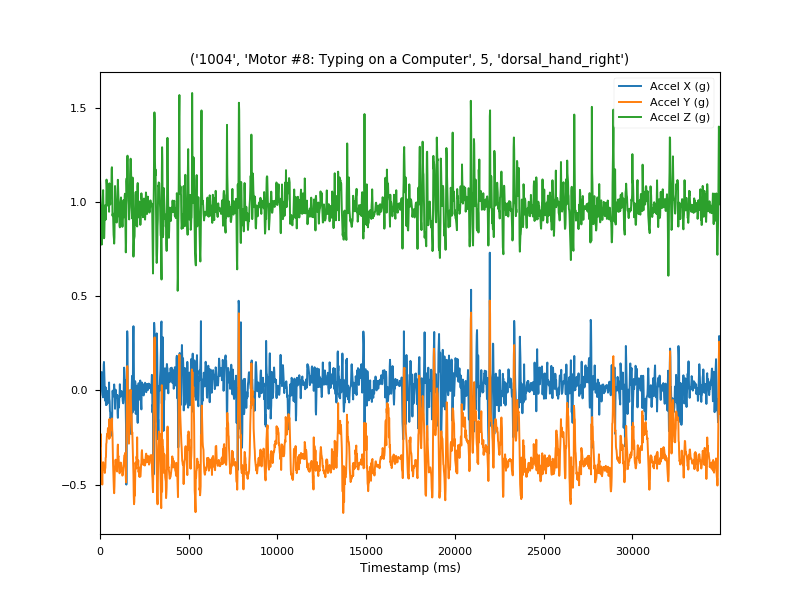

<IPython.core.display.Javascript object>


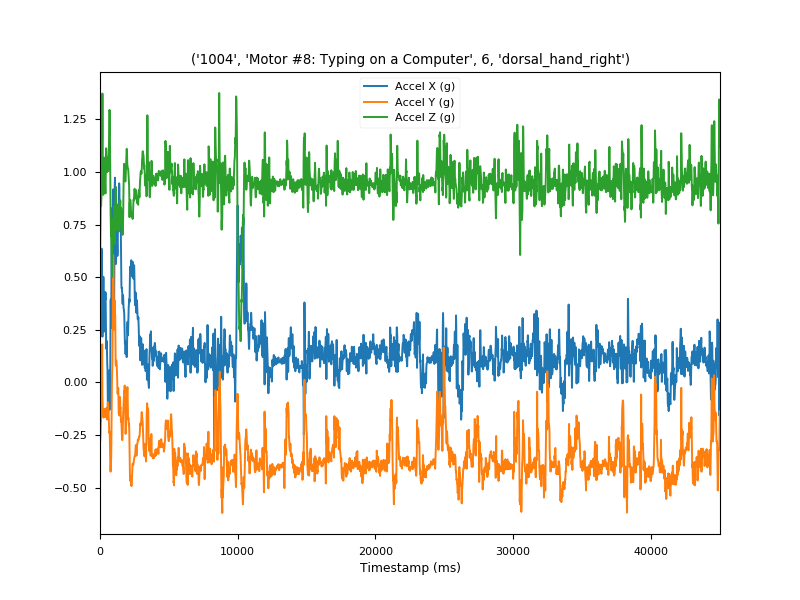

In [10]:
sns.set_context('paper')
p = product([task],trials)
taskslist = list(p)
for t in taskslist:
    plot_data(act_dict,t[0],t[1],loc,'accel')
    plt.title(tuple([str(subj)])+t+tuple([loc]))

<IPython.core.display.Javascript object>


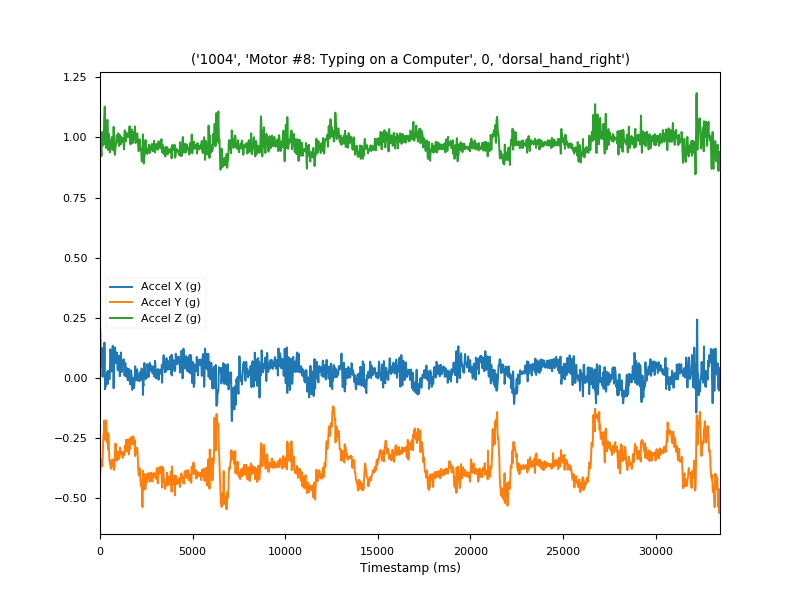

<IPython.core.display.Javascript object>


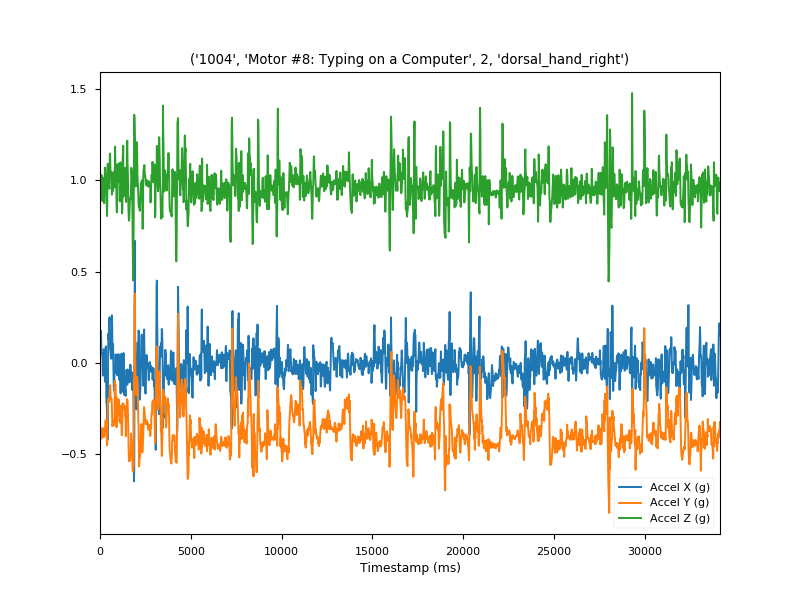

<IPython.core.display.Javascript object>


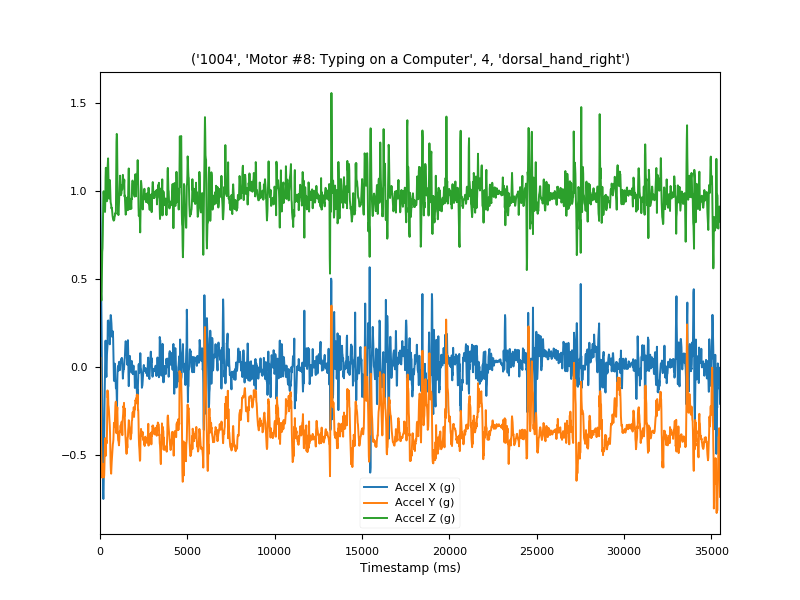

<IPython.core.display.Javascript object>


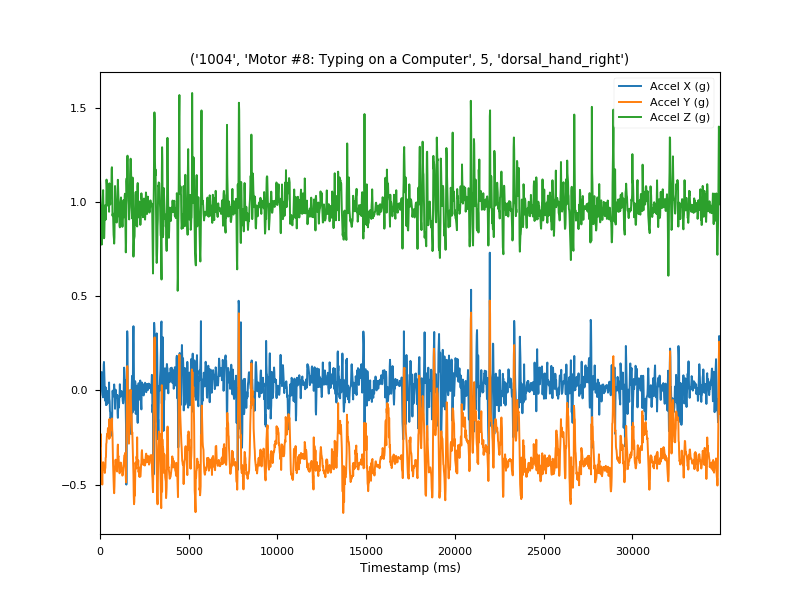

<IPython.core.display.Javascript object>


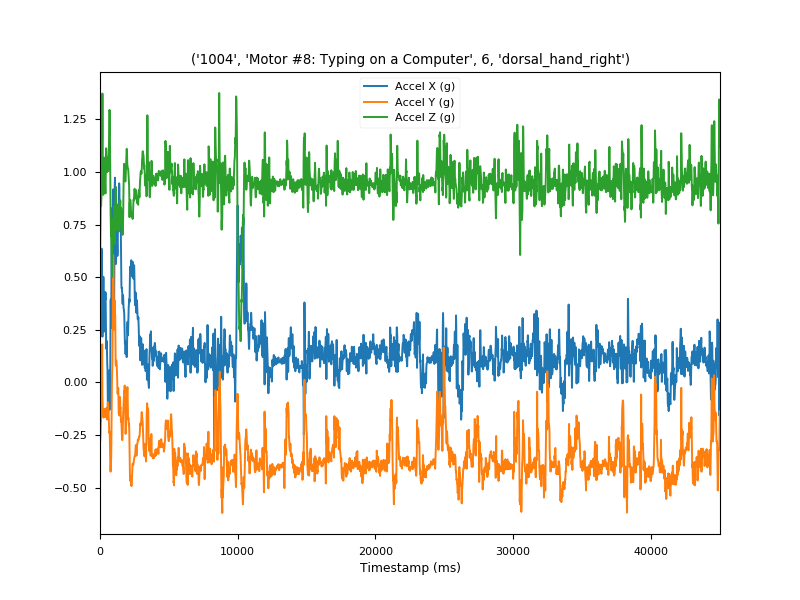

In [11]:
sns.set_context('paper')
p = product([task],trials)
taskslist = list(p)
for t in taskslist:
    plot_data(act_dict,t[0],t[1],loc,'accel')
    plt.title(tuple([str(subj)])+t+tuple([loc]))

# List of activities / sensor locations

In [12]:
sorted(list(act_dict.keys()))

['Heart Rate Variability',
 'MDS-UPDRS #10: Kinetic Hand Tremor',
 'MDS-UPDRS #11: Rest Tremor',
 'MDS-UPDRS #1: Finger Tapping',
 'MDS-UPDRS #2: Hand Movements',
 'MDS-UPDRS #3: Pronation-Supination',
 'MDS-UPDRS #4: Toe Tapping',
 'MDS-UPDRS #5: Leg Agility',
 'MDS-UPDRS #6: Arising from Chair',
 'MDS-UPDRS #7: Gait',
 'MDS-UPDRS #8: Postural Stability',
 'MDS-UPDRS #9: Postural Hand Tremor',
 'Motor #10: Drinking Water',
 'Motor #11: Organizing Folder',
 'Motor #12: Folding Towels',
 'Motor #13: Sitting',
 'Motor #1: Standing',
 'Motor #2: Walking',
 'Motor #3: Walking while Counting',
 'Motor #4: Finger to Nose',
 'Motor #5: Alternating Hand Movements',
 'Motor #6: Sit to Stand',
 'Motor #7: Drawing on Paper',
 'Motor #8: Typing on a Computer',
 'Motor #9: Nuts and Bolts']

In [13]:
sorted(list(act_dict[ 'Motor #2: Walking'][0].keys()))

['anterior_thigh_left',
 'anterior_thigh_right',
 'distal_lateral_shank_left',
 'distal_lateral_shank_right',
 'dorsal_hand_left',
 'dorsal_hand_right',
 'flexor_digitorum_left',
 'flexor_digitorum_right',
 'medial_chest',
 'sacrum']